In [1]:
import svox2
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
intr = np.array([[380,   0, 320, 0],
                 [  0, 380, 180, 0],
                 [  0,   0,   1, 0],
                 [  0,   0,   0, 0]])

c2w = np.eye(4)

In [3]:
def get_camera_rays(W, H, intrinsics, c2w):
    u, v = np.meshgrid(np.arange(W), np.arange(H))

    u = u.reshape(-1).astype(dtype=np.float32) + 0.5  # add half pixel
    v = v.reshape(-1).astype(dtype=np.float32) + 0.5
    pixels = np.stack((u, v, np.ones_like(u)), axis=0)  # (3, H*W)

    rays_d = np.dot(np.linalg.inv(intrinsics[:3, :3]), pixels) # sensor's location to camera

    rays_d = np.dot(c2w[:3, :3], rays_d)  # (3, H*W)
    rays_d = rays_d.transpose((1, 0))  # (H*W, 3)

    rays_o = c2w[:3, 3].reshape((1, 3))
    rays_o = np.tile(rays_o, (rays_d.shape[0], 1))  # (H*W, 3)

    rays = svox2.Rays(torch.from_numpy(rays_o).double().cuda(), torch.from_numpy(rays_d).double().cuda().contiguous())

    return rays

rays = get_camera_rays(1, 1, intr, c2w)

In [4]:
grid = svox2.SparseGrid(reso=12).requires_grad_(False)
grid.sh_data.normal_()
grid = grid.cuda().requires_grad_(True)
density_data = grid.density_data

In [5]:
grid = grid.double()

depth = f(rays)
depth_np = depth.view(640, 480).detach().cpu().numpy()
plt.imshow(depth_np)

In [6]:
inp = (torch.rand_like(density_data)).double().requires_grad_(True)


In [7]:
def fv(x):
    cgrid = grid._to_cpp()
    cgrid.density_data = x
    cgrid.background_data = False
    cgrid.basis_data = cgrid.basis_data.double()
    cgrid.background_data = cgrid.background_data.double()
    cgrid.sh_data = cgrid.sh_data.double()
    out = svox2.svox2._VolumeRenderFunction.apply(x, grid.sh_data, None, None,
                                                  cgrid, rays._to_cpp(), grid.opt._to_cpp(), "cuvol")
    #print(out.mean(), out.std())
    return out

def fd(x):
    cgrid = grid.double()._to_cpp()
    cgrid.density_data = x
    out = svox2.svox2._DepthRenderFunction.apply(x, 
                                                  cgrid, rays._to_cpp(), grid.opt._to_cpp())
    #print(out.mean(), out.std())
    return out

f = fd

In [47]:
@torch.no_grad()
def finite_diff(f, x, eps=1e-4):
    N = x.shape[-1]
    g = torch.zeros_like(x)
    I = torch.eye(N).type_as(x)
    for i in range(N):
        f1 = f(x + eps * I[i])
        f2 = f(x - eps * I[i])
        g[i] = (f1 - f2) / (2 * eps)
    return g

def autodiff(f, x):
    x = x.requires_grad_(True)
    y = f(x)
    g = torch.autograd.grad(y, x)[0]
    return g

def relative_diff(f1, f2, eps=1e-12):
    f1n = f1.norm()
    f2n = f2.norm()
    if f2n < eps:
        return torch.tensor(0.)
    
    fdn = (f2 - f1).norm()
    return fdn / f2n

In [48]:
fdiff = finite_diff(fd, inp, eps=1e-12)
fad = autodiff(fd, inp)

In [49]:
relative_diff(fad, fdiff)

tensor(0.)

In [53]:
eps = np.linspace(0.1, 1e-17, 1000)
err = []
rerr = []
fdn = []
fan = []
for ep in eps:
    f1 = autodiff(fd, inp)
    fdiff = finite_diff(fd, inp, eps=ep)
    err.append((f1 - fdiff).norm().item())
    rerr.append(relative_diff(f1, fdiff).item())
    fdn.append(fdiff.norm().item())
    fan.append(f1.norm().item())

Text(0.5, 1.0, 'Relative gradient error as a function of epsilon')

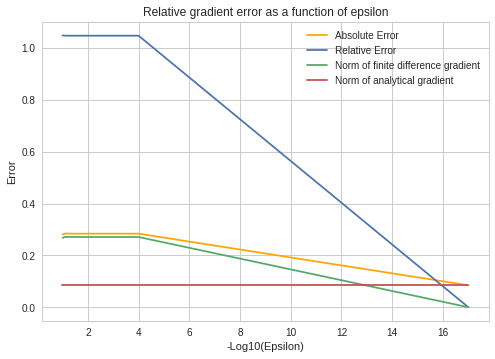

In [56]:
xaxis = -1 * np.log10(eps)
plt.style.use("seaborn-whitegrid")
plt.plot(xaxis, err, label="Absolute Error", c ='orange')
plt.plot(xaxis, rerr, label="Relative Error")
plt.plot(xaxis, fdn, label="Norm of finite difference gradient")
plt.plot(xaxis, fan, label="Norm of analytical gradient")
plt.legend()
plt.xlabel("-Log10(Epsilon)")
plt.ylabel("Error")
plt.title("Relative gradient error as a function of epsilon")